In [1]:
import numpy as np
import re
import random
import itertools
import datetime

import tensorflow as tf
import sklearn as sk

from gensim.models import Word2Vec

import Functions as fn
from DS import DS
from Set import pool
from Iterator import Iterator
from FFModel import FF_Model

c:\users\luka\anaconda3\envs\tensorflow13\lib\site-packages\gensim\utils.py:865: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


# Data Loading

In [2]:
Dataset = pool()
Dataset.load_texts('raw_texts')
Dataset.load_labels('raw_labels')

Raw Text Load Complete
Raw Labels Load Complete


In [3]:
#print('Number of Texts: ', Dataset.size)
#print('Number of 2007 Smoking Challenge texts: ', Dataset.number_of(challenge='2007 Smoking Challenge'))
#print('Number of 2008 ObesityChallenge texts: ', Dataset.number_of(challenge='2008 Obesity Challenge'))
#print('Number of 2009 Medication Challenge texts: ', Dataset.number_of(challenge='2009 Medication Challenge'))
#print('Number of 2010 Relations Challenge texts: ', Dataset.number_of(challenge='2010 Relations Challenge'))
#print('Number of 2011 Coreference Challenge texts: ', Dataset.number_of(challenge='2011 Coreference Challenge'))
#print('Number of 2012 Temporal Relations Challenge texts: ', Dataset.number_of(challenge='2012 Temporal Relations Challenge'))
#print('Number of Train Texts: ', Dataset.number_of(stage='train'))
#print('Number of Test Texts: ', Dataset.number_of(stage='test'))
#print('Number of Labeled Texts: ', Dataset.number_of(labelled='yes'))
#print('Number of Initially Labeled Texts: ', Dataset.number_of(labelled='yes', label_type='train'))
#print('Number of Competitor Labeled Texts Texts: ', Dataset.number_of(labelled='yes', label_type='test'))

In [4]:
target_dict = fn.load_labels('final_meta/labels')

Label Load Complete


# Embedding Generation

In [5]:
train_set = pool(data=(Dataset.get_DS(stage='test', labelled='yes')).data[:-10])
validation_set = pool(data=(Dataset.get_DS(stage='test', labelled='yes')).data[-10:])
test_set = Dataset.get_DS(stage='train', labelled='yes')
set_1 = Dataset.get_DS(stage='train', labelled='no')
set_2 = Dataset.get_DS(stage='test', labelled='no')
set_1.append(set_2.data)
set_1.append(train_set.data)
emb_set = set_1
print(emb_set.size, train_set.size, validation_set.size, test_set.size)

4585 238 10 10


In [29]:
#emb_set.process_for_embedding()
#sentences = emb_set.get_sentences()
#fn.write_sentences(sentences, 'final_meta/sentences')
sentences = fn.load_sentences('final_meta/sentences')

#model = Word2Vec(sentences, min_count=1, size=100)
#model.save('final_meta/W2V')
model = Word2Vec.load('final_meta/W2V')

vocab = model.wv.vocab.keys()

Sentence Load Complete


# Large Scale AED and ACS

# Visualisation

# Naive Test 

Target: medications	Repetitions: True


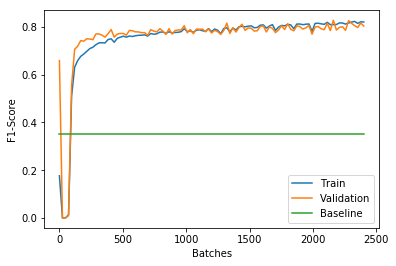

FInal Values: Tr-F1: 0.8212, Val-F1: 0.8042
Test F1-Score: 0.8065



In [30]:
for target in ['medications']:
    for reps in [True]:
        target_size = len(target_dict[target])
        word_sets = fn.generate_naive_traintest(vocab, target_dict[target], target_size * 5, target_size, 10, 50, reps, reps)
        emb_sets = fn.embed_words(word_sets, model)
        emb_sets['validation_set'] = emb_sets['test_set']
        emb_sets['validation_labels'] = emb_sets['test_labels']
        print("Target: {}\tRepetitions: {}".format(target, reps))
        NN = FF_Model(layers=[100], activ='sigmoid', dropout=1.0, learn_rate=0.01)
        NN.build_graph()
        cbowtr, cbowtest, _ =NN.train(emb_sets, epochs=20, batch=50, report_percentage=1, show_progress=True, show_plot=True)

In [31]:
model = Word2Vec(sentences, sg=1, min_count=1, size=100)

Target: medications	Repetitions: True


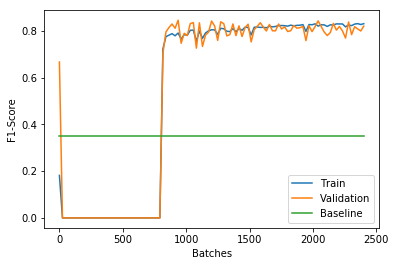

FInal Values: Tr-F1: 0.8304, Val-F1: 0.8199
Test F1-Score: 0.7937



In [32]:
for target in ['medications']:
    for reps in [True]:
        target_size = len(target_dict[target])
        word_sets = fn.generate_naive_traintest(vocab, target_dict[target], target_size * 5, target_size, 10, 50, reps, reps)
        emb_sets = fn.embed_words(word_sets, model)
        emb_sets['validation_set'] = emb_sets['test_set']
        emb_sets['validation_labels'] = emb_sets['test_labels']
        print("Target: {}\tRepetitions: {}".format(target, reps))
        NN = FF_Model(layers=[100], activ='sigmoid', dropout=1.0, learn_rate=0.01)
        NN.build_graph()
        csgwtr, csgtest, _ = NN.train(emb_sets, epochs=20, batch=50, report_percentage=1, show_progress=True, show_plot=True)

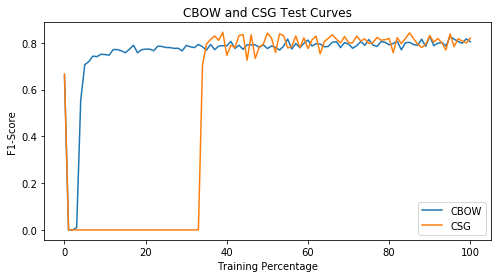

In [34]:
from matplotlib import pyplot as plt

points = np.array(range(101))

fig = plt.figure(figsize=(8, 4))
plt.subplots_adjust(hspace=0.4)
plt.plot(points, cbowtest, label="CBOW")
plt.plot(points, csgtest, label="CSG")
plt.xlabel("Training Percentage")
plt.ylabel("F1-Score")
plt.title('CBOW and CSG Test Curves')
plt.legend()
plt.show()

# HyperParameter Scan

In [ ]:
emb_model = {'CBOW': 0, 'CSG': 1}
layers = [100]
layer_num = [1, 2]
activ = ['sigmoid', 'relu', 'tanh']
dropouts = [1, 0.8, 0.6]
learn_rates = [0.001, 0.01]
epoch_nums = [50]
NN_num = 5

target_names = ['medications', 'dosages', 'modes']
targets = [target_dict[t_name] for t_name in target_names] 

model_num = len(emb_model) * len(layers) * len(layer_num) * len(activ) * len(dropouts) * len(learn_rates) * len(epoch_nums) * NN_num * len(targets)


print(model_num)

In [ ]:
%%capture
n = 0

for i in range(len(target_names)):
    word_sets = fn.generate_naive_traintest(vocab=vocab,
                                        labels=targets[i],
                                        train_size=10000,
                                        test_size=1000,
                                        train_label_percentage=10,
                                        test_label_percentage=10,
                                        word_repetition = True,
                                        label_repetition = True)
    iterations = [layers, layer_num, activ, dropouts, learn_rates, epoch_nums]
    timestamp = re.sub(r':', '-', str(datetime.datetime.now()).split('.')[0])
    results = []
    with open('tests/Model1/' + target_names[i] + '/' + timestamp, 'w+') as f:    
        print('Model\tLay:\tLN:\tAct:\tDrop:\tLeRa:\tEpochs:\tF1:')
        f.write(target_names[i] + '\n')
        f.write('Model\tLay:\tLN:\tAct:\tDrop:\tLeRa:\tEpochs:\tF1:\n')
        for modeltype in emb_model.keys():
            model = Word2Vec(sentences, sg=emb_model[modeltype], min_count=1, size=100)
            emb_sets = fn.embed_words(word_sets, model)
            emb_sets['validation_set'] = emb_sets['test_set']
            emb_sets['validation_labels'] = emb_sets['test_labels']
            for par in itertools.product(*iterations):
                best = 0
                lay = []
                for j in range(par[1]):
                    lay.append(par[0])
                NN = FF_Model(layers=lay, activ=par[2], dropout=par[3], learn_rate=par[4])
                NN.build_graph()
                for k in range(NN_num):
                    n += 1
                    print('Model Number: {}/{}'.format(n, model_num), end='\r')
                    _, _, score = NN.train(emb_sets, epochs=par[5], batch=50)
                    NN.close()
                    best = max(best, score)
                results.append(best)
                print('{}\t{}\t{}\t{}\t{}\t{}\t{}\t{:.4f}'.format(modeltype, *par, results[-1]))
                f.write('{}\t{}\t{}\t{}\t{}\t{}\t{}\t{:.4f}\n'.format(modeltype, *par, results[-1]))

        print('Max Performance: {:.4f}'.format(max(results)))  
        f.write('Max Performance: {:.4f}\n'.format(max(results)))